# 導入

In [ ]:
# pip install lightgbm
# pip install matplotlib
# pip install graphviz
# pip install --upgrade pip #pipのバージョン更新
# pip install scikit-learn
# pip install sklearn
# pip install optuna
# pip install optuna-integration

# インポート

In [8]:
import pandas as pd
from pathlib import Path

COMMON_DATA_DIR = Path("..", "..", "common", "data")
RAWDF_DIR = COMMON_DATA_DIR / "rawdf"

# 学習母集団の作成
期間を指定すると、学習母集団である(日付、race_id, horse_id)の組を作る

# データ加工

## レース結果テーブルの加工

In [3]:
df = pd.read_csv(RAWDF_DIR / "results.csv", sep="\t")

In [32]:
# 列数を絞って、どこを加工していくかを調べる
# iloc第1引数は行範囲、第2引数は列範囲　「:」はすべてが対象
df.iloc[:, 0:10]

,race_id,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差
0,202301010101,1,5,5,サトミノキラリ,牡2,55.0,横山武史,1:09.5,NaN
1,202301010101,2,8,8,ベアゴーゴー,牝2,55.0,浜中俊,1:09.5,クビ
2,202301010101,3,6,6,ハピアーザンエバー,牡2,55.0,藤岡佑介,1:10.0,2.1/2
3,202301010101,4,4,4,デビルシズカチャン,牝2,55.0,ルメール,1:10.2,1.1/2
4,202301010101,5,1,1,ウィスピースノー,牝2,55.0,吉田隼人,1:10.3,1/2
...,...,...,...,...,...,...,...,...,...,...
47667,202310030812,8,1,1,リヴァーレ,牝3,53.0,太宰啓介,2:42.9,1.1/4
47668,202310030812,9,6,7,シュアーウィナー,牡5,55.0,川端海翼,2:43.5,3.1/2
47669,202310030812,10,2,2,アウローラシエル,牡3,55.0,和田竜二,2:43.6,3/4
47670,202310030812,11,4,4,ハイグッドエース,牡4,55.0,西塚洸二,2:43.7,3/4


In [8]:
df["着順"].astype(int) # 数値以外の値が混じった場合は例外で変換失敗となる

ValueError: invalid literal for int() with base 10: '除'

In [9]:
# errors="coerce"で変換できない場合は欠損値（NaN）で変換される
# デフォルトはerrors="raise"で変換できない場合は例外スローされる
df["rank"] = pd.to_numeric(df["着順"], errors="coerce")
# 欠損値も含めて（dropna=False）それぞれの値の件数を確認
# デフォルトはdropna="True"で欠損値は集計されない
df["rank"].value_counts(dropna=False)

rank
3.0     3460
1.0     3459
2.0     3456
4.0     3456
5.0     3456
6.0     3443
7.0     3424
8.0     3367
9.0     3259
10.0    3101
11.0    2895
12.0    2637
13.0    2342
14.0    2047
15.0    1708
16.0    1279
NaN      399
17.0     280
18.0     204
Name: count, dtype: int64

In [10]:
# subsetは欠損値を除外
# inplace=Trueはdf変更が反映される
df.dropna(subset=["rank"], inplace=True)

In [11]:
df["rank"].value_counts(dropna=False)

rank
3.0     3460
1.0     3459
2.0     3456
4.0     3456
5.0     3456
6.0     3443
7.0     3424
8.0     3367
9.0     3259
10.0    3101
11.0    2895
12.0    2637
13.0    2342
14.0    2047
15.0    1708
16.0    1279
17.0     280
18.0     204
Name: count, dtype: int64

In [12]:
df["枠番"].astype(int)

0        5
1        8
2        6
3        4
4        1
        ..
47667    1
47668    6
47669    2
47670    4
47671    5
Name: 枠番, Length: 47273, dtype: int64

In [13]:
df["馬番"].astype(int)

0        5
1        8
2        6
3        4
4        1
        ..
47667    1
47668    7
47669    2
47670    4
47671    5
Name: 馬番, Length: 47273, dtype: int64

In [14]:
df["性齢"].str[0].value_counts()

性齢
牡    25038
牝    19922
セ     2313
Name: count, dtype: int64

ラベルエンコーディング：カテゴリ変数を整数にマッピングするデータ加工手法

In [15]:
sex_mapping = {"牡":0, "牝":1, "セ":2}

In [16]:
df["性齢"].str[0].map(sex_mapping).value_counts()

性齢
0    25038
1    19922
2     2313
Name: count, dtype: int64

In [17]:
df["性齢"].str[1:].value_counts()

性齢
3     19797
4      9059
2      8017
5      5951
6      2861
7      1050
8       355
9       123
10       37
11       12
12       11
Name: count, dtype: int64

In [18]:
df["性齢"].str[1:].astype(int)

0        2
1        2
2        2
3        2
4        2
        ..
47667    3
47668    5
47669    3
47670    4
47671    3
Name: 性齢, Length: 47273, dtype: int64

In [19]:
df["単勝"].astype(float)

0          1.2
1          4.1
2         59.9
3         16.6
4         23.9
         ...  
47667     62.8
47668    125.6
47669      9.8
47670     37.2
47671      6.2
Name: 単勝, Length: 47273, dtype: float64

In [30]:
df["人気"].astype(int)

0         1
1         2
2         6
3         3
4         5
         ..
47667    11
47668    12
47669     5
47670    10
47671     4
Name: 人気, Length: 47273, dtype: int64

In [21]:
df["馬体重"]

0         452(-4)
1         454(+2)
2         438(-6)
3         450(+2)
4        434(-10)
           ...   
47667     394(+2)
47668     470(-4)
47669     496(+8)
47670     440(-2)
47671     442(+6)
Name: 馬体重, Length: 47273, dtype: object

In [25]:
# 「d+」は数字の繰り返しまでの部分
df["weight"] = df["馬体重"].str.extract(r"(\d+)").astype(int)
df["weight"]

0        452
1        454
2        438
3        450
4        434
        ... 
47667    394
47668    470
47669    496
47670    440
47671    442
Name: weight, Length: 47273, dtype: int64

In [28]:
# 「.」は任意の文字列、エスケープ[\]で()の中に任意の文字列を取り出す
df["weight_diff"] = df["馬体重"].str.extract(r"\((.+)\)").astype(int)

In [29]:
df["weight_diff"]

0        -4
1         2
2        -6
3         2
4       -10
         ..
47667     2
47668    -4
47669     8
47670    -2
47671     6
Name: weight_diff, Length: 47273, dtype: int64

## 馬の過去成績テーブル

In [4]:
df = pd.read_csv(RAWDF_DIR / "horse_results.csv", sep="\t")

In [45]:
df["天気"].value_counts()

天気
晴     95494
曇     49248
雨     10112
小雨     5825
雪       177
小雪      135
Name: count, dtype: int64

In [7]:
import preprocessing

race_info = preprocessing.process_race_info()

In [8]:
race_info

,race_id,date,race_type,around,course_len,weather,ground_state,race_class,place
0,202301010101,2023-07-22,1,0.0,1200,0,0,1,1
1,202301010102,2023-07-22,0,0.0,1000,0,0,1,1
2,202301010103,2023-07-22,0,0.0,1700,0,0,1,1
3,202301010104,2023-07-22,1,0.0,1500,0,0,1,1
4,202301010105,2023-07-22,0,0.0,1700,0,0,0,1
...,...,...,...,...,...,...,...,...,...
3451,202310030808,2023-09-03,0,0.0,1000,0,0,2,10
3452,202310030809,2023-09-03,1,0.0,1200,0,0,3,10
3453,202310030810,2023-09-03,0,0.0,1700,0,0,4,10
3454,202310030811,2023-09-03,1,0.0,1200,0,0,5,10


# 特徴量作成

In [5]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("..", "data")

In [6]:
results = pd.read_csv(DATA_DIR / "01_preprocessed" / "results.csv", sep="\t")
horse_results = pd.read_csv(DATA_DIR / "01_preprocessed" / "horse_results.csv", sep="\t")

In [47]:
results

,race_id,horse_id,jockey_id,trainer_id,owner_id,rank,wakuban,umaban,sex,age,weight,weight_diff,tansho_odds,popularity,impost
0,202301010101,2021100648,1095,1128,281008,5,1,1,1,2,434,-10,23.9,5,55.0
1,202301010101,2021100159,1157,1186,170800,6,2,2,0,2,454,-6,61.8,7,55.0
2,202301010101,2021100265,1197,1192,320803,7,3,3,1,2,404,-2,18.8,4,53.0
3,202301010101,2021105553,5339,1160,680031,4,4,4,1,2,450,2,16.6,3,55.0
4,202301010101,2021101429,1170,1026,425031,1,5,5,0,2,452,-4,1.2,1,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47268,202310030812,2019102542,1208,1161,17803,1,6,8,1,4,442,-2,3.5,1,53.0
47269,202310030812,2020103754,1116,1104,651031,6,7,9,0,3,468,0,15.2,8,55.0
47270,202310030812,2020100400,1193,1092,180800,4,7,10,1,3,458,6,23.1,9,50.0
47271,202310030812,2020103663,732,1092,226800,2,8,11,2,3,486,-6,5.0,3,55.0


In [53]:
horse_id_list = [
    2018102264,
    2020102750
]


In [54]:
horse_results.query("horse_id in @horse_id_list")

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses
0,2018102264,2024-01-21,10.0,0.0,1.0,1.0,0,1200,1.0,4.0,16
1,2018102264,2023-12-09,5.0,184.0,0.5,0.0,0,1200,0.0,4.0,16
2,2018102264,2023-07-23,4.0,275.0,0.2,0.0,0,1150,0.0,5.0,11
3,2018102264,2023-06-11,7.0,0.0,0.3,1.0,0,1200,1.0,4.0,16
4,2018102264,2023-04-02,9.0,0.0,1.5,0.0,0,1200,0.0,4.0,16
5,2018102264,2023-01-07,4.0,280.0,0.6,0.0,0,1200,0.0,4.0,15
6,2018102264,2022-12-25,5.0,184.0,0.3,0.0,0,1200,2.0,4.0,16
7,2018102264,2022-11-05,11.0,0.0,1.0,0.0,0,1200,0.0,4.0,16
8,2018102264,2022-09-11,9.0,0.0,1.0,0.0,0,1200,2.0,4.0,16
9,2018102264,2022-05-28,1.0,1110.0,0.0,0.0,0,1200,2.0,3.0,16


In [48]:
horse_results

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses
0,2018102264,2024-01-21,10.0,0.0,1.0,1.0,0,1200,1.0,4.0,16
1,2018102264,2023-12-09,5.0,184.0,0.5,0.0,0,1200,0.0,4.0,16
2,2018102264,2023-07-23,4.0,275.0,0.2,0.0,0,1150,0.0,5.0,11
3,2018102264,2023-06-11,7.0,0.0,0.3,1.0,0,1200,1.0,4.0,16
4,2018102264,2023-04-02,9.0,0.0,1.5,0.0,0,1200,0.0,4.0,16
...,...,...,...,...,...,...,...,...,...,...,...
159382,2020102750,2023-12-27,1.0,40.0,0.0,0.0,0,1400,0.0,NaN,7
159383,2020102750,2023-12-06,3.0,8.0,0.4,0.0,0,1400,0.0,NaN,8
159384,2020102750,2023-11-07,5.0,2.0,2.3,1.0,0,800,1.0,NaN,7
159385,2020102750,2023-09-03,14.0,0.0,3.4,0.0,0,1700,0.0,1.0,16


# 競馬AIの実行イメージ

In [5]:
from feature_engineering import FeatureCreator

In [2]:
# インスタンス化
fc = FeatureCreator()
fc.results

,race_id,horse_id,jockey_id,trainer_id,owner_id,rank,wakuban,umaban,sex,age,weight,weight_diff,tansho_odds,popularity,impost
0,202301010101,2021100648,1095,1128,281008,5,1,1,1,2,434,-10,23.9,5,55.0
1,202301010101,2021100159,1157,1186,170800,6,2,2,0,2,454,-6,61.8,7,55.0
2,202301010101,2021100265,1197,1192,320803,7,3,3,1,2,404,-2,18.8,4,53.0
3,202301010101,2021105553,5339,1160,680031,4,4,4,1,2,450,2,16.6,3,55.0
4,202301010101,2021101429,1170,1026,425031,1,5,5,0,2,452,-4,1.2,1,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47268,202310030812,2019102542,1208,1161,17803,1,6,8,1,4,442,-2,3.5,1,53.0
47269,202310030812,2020103754,1116,1104,651031,6,7,9,0,3,468,0,15.2,8,55.0
47270,202310030812,2020100400,1193,1092,180800,4,7,10,1,3,458,6,23.1,9,50.0
47271,202310030812,2020103663,732,1092,226800,2,8,11,2,3,486,-6,5.0,3,55.0


In [3]:
# 特徴量作成の実行
features = fc.create_features()

In [4]:
features[["rank_3races", "price_3races", "rank_5races", "price_5races", "rank_10races", "price_10races", "rank_1000races", "price_1000races"]]

,rank_3races,price_3races,rank_5races,price_5races,rank_10races,price_10races,rank_1000races,price_1000races
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
47268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47269,8.000000,40.000000,6.0,145.0,6.125000,90.625000,6.125000,90.625000
47270,8.000000,0.000000,8.8,0.0,8.800000,0.000000,8.800000,0.000000
47271,5.666667,61.666667,6.2,97.0,5.666667,123.222222,5.666667,123.222222


In [6]:
features.columns

Index(['race_id', 'horse_id', 'date', 'jockey_id', 'trainer_id', 'owner_id',
       'rank', 'wakuban', 'umaban', 'sex', 'age', 'weight', 'weight_diff',
       'tansho_odds', 'popularity', 'impost', 'race_type', 'around',
       'course_len', 'weather', 'ground_state', 'race_class', 'place', 'month',
       'sin_date', 'cos_date', 'rank_3races', 'price_3races', 'rank_5races',
       'price_5races', 'rank_10races', 'price_10races', 'rank_1000races',
       'price_1000races'],
      dtype='object')

In [7]:
feature_cols = [
    'horse_id',
    'jockey_id',
    'trainer_id',
    'wakuban',
    'umaban',
    'sex',
    'age',
    'weight',
    'weight_diff',
    'tansho_odds',
    'popularity',
    'impost',
    'race_type',
    'around',
    'course_len',
    'weather',
    'ground_state',
    'race_class',
    'place',
    'rank_3races',
    'price_3races',
    'rank_5races',
    'price_5races',
    'rank_10races',
    'price_10races',
    'rank_1000races',
    'price_1000races'
]

In [8]:
# 説明変数（予測材料として機械学習モデルにインプットするもの）
X = features[feature_cols]

In [9]:
# 目的変数（予測対象）
y = (features["rank"] == 1).astype(int)

In [10]:
y

0        0
1        0
2        0
3        0
4        1
        ..
47268    1
47269    0
47270    0
47271    0
47272    0
Name: rank, Length: 47273, dtype: int64

In [11]:
features["target"] = (features["rank"] == 1).astype(int)

# ホールドアウト法


## データを学習データと検証データに分ける

In [12]:
train_df = features.query("date < '2023-10-01'")
test_df = features.query("date >= '2023-10-01'")

In [13]:
len(train_df), len(test_df)

(35524, 11749)

## LightGBMによる学習

In [14]:
import lightgbm as lgb

# データセットの作成
lgb_train = lgb.Dataset(
    train_df[feature_cols], train_df["target"]
)
lgb_test = lgb.Dataset(
    test_df[feature_cols], test_df["target"]
)

# パラメータの設定
params = {
    "objective": "binary", # 二値分類(0か1)
    "metric": "binary_logloss", # 予測誤差
    "random_state": 100 # 実行ごとに同じ結果を得るための設定
}

# 学習の実行
model = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.log_evaluation()]
)

[LightGBM] [Info] Number of positive: 2595, number of negative: 32929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 35524, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073049 -> initscore=-2.540767
[LightGBM] [Info] Start training from score -2.540767
[1]	training's binary_logloss: 0.24629	valid_1's binary_logloss: 0.248751
[2]	training's binary_logloss: 0.236948	valid_1's binary_logloss: 0.240581
[3]	training's binary_logloss: 0.230078	valid_1's binary_logloss: 0.234485
[4]	training's binary_logloss: 0.224547	valid_1's binary_logloss: 0.229584
[5]	training's binary_logloss: 0.220073	valid_1's binary_logloss: 0.225872
[6]	training's binary_logloss: 0.216354	valid_1's binary_logloss: 0.222847
[7]	training's binary_logloss: 0.213193	valid_1's binary_l

## オフライン評価

的中率・回収率をみてみる

In [15]:
# テストデータに対して予測をしてみる
model.predict(test_df[feature_cols])

array([0.32937236, 0.00059501, 0.00173569, ..., 0.00056062, 0.0027764 ,
       0.00071019], shape=(11749,))

In [15]:
evaluation_df = test_df[
    [
        "race_id",
        "horse_id",
        "target",
        "rank",
        "tansho_odds",
        "popularity"
    ]
].copy()
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity
6254,202303030101,2021100761,0,10,2.1,1
6255,202303030101,2021106736,0,14,398.2,15
6256,202303030101,2021107376,0,15,177.5,12
6257,202303030101,2021109129,0,7,94.7,7
6258,202303030101,2021103986,0,12,173.0,11
...,...,...,...,...,...,...
43507,202309050912,2019103898,0,2,5.9,3
43508,202309050912,2019106102,0,8,11.9,6
43509,202309050912,2017102603,0,16,347.8,14
43510,202309050912,2019100653,0,13,94.7,12


In [16]:
evaluation_df["pred"] = model.predict(test_df[feature_cols])

In [17]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
6254,202303030101,2021100761,0,10,2.1,1,0.330468
6255,202303030101,2021106736,0,14,398.2,15,0.003484
6256,202303030101,2021107376,0,15,177.5,12,0.001075
6257,202303030101,2021109129,0,7,94.7,7,0.007974
6258,202303030101,2021103986,0,12,173.0,11,0.001685
...,...,...,...,...,...,...,...
43507,202309050912,2019103898,0,2,5.9,3,0.170860
43508,202309050912,2019106102,0,8,11.9,6,0.061860
43509,202309050912,2017102603,0,16,347.8,14,0.000261
43510,202309050912,2019100653,0,13,94.7,12,0.005012


predの値が一番高いものに、単勝馬券で賭ける場合を考える

In [18]:
bet_df = (
    evaluation_df
    .sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(1)
)
bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
16665,202305040110,2020106565,0,3,1.3,1,0.848118
17919,202305040911,2019105219,1,1,1.3,1,0.831660
17781,202305040811,2021105643,1,1,1.5,1,0.827596
25387,202306050309,2021105122,1,1,1.5,1,0.827469
30992,202307040208,2021105661,0,2,1.5,1,0.824593
...,...,...,...,...,...,...,...
42071,202309040910,2019105746,1,1,7.2,5,0.132143
11481,202304040510,2019101262,0,15,14.6,7,0.129475
26461,202306050908,2019106520,0,6,4.8,2,0.128852
31701,202307040610,2018105163,0,9,5.7,3,0.126216


In [19]:
# 的中率
bet_df["target"].mean()

np.float64(0.33564814814814814)

In [20]:
# 返ってる金額
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
return_

np.float64(722.3)

In [21]:
# かけた金額
cost = len(bet_df)
cost

864

In [22]:
# 回収率
return_ /cost

np.float64(0.8359953703703703)

In [23]:
# 一番人気に賭け続けた場合に勝っているか
bet_df = (
    evaluation_df
    .sort_values("popularity")
    .groupby("race_id")
    .head(1)
)
bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
25997,202306050702,2021105516,1,1,3.3,1,0.229282
25961,202306050612,2019100861,0,4,3.5,1,0.160744
17115,202305040408,2020103534,0,3,3.6,1,0.198968
42466,202309050307,2021106738,1,1,2.0,1,0.471614
18624,202305050504,2021105536,1,1,2.6,1,0.318274
...,...,...,...,...,...,...,...
6275,202303030102,2021104112,0,3,2.0,1,0.461958
6294,202303030104,2019100577,0,7,2.7,1,0.125905
6254,202303030101,2021100761,0,10,2.1,1,0.330468
42620,202309050409,2018110137,0,2,3.0,2,0.179255


In [24]:
# 的中率
bet_df["target"].mean()

np.float64(0.33101851851851855)

In [25]:
# 回収率
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ /cost

np.float64(0.7987268518518519)

In [26]:
# 一番人気と違う馬の回収率
bet_df = (
    evaluation_df
    .sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(1)
    .query("popularity != 1")
)
bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
18491,202305050407,2019110009,1,1,4.0,2,0.582713
16558,202305040102,2021105476,0,5,3.2,2,0.574603
42981,202309050611,2021105744,0,10,3.9,2,0.526853
26192,202306050803,2021110001,1,1,2.2,2,0.449780
18629,202305050504,2021105788,0,3,2.9,2,0.435491
...,...,...,...,...,...,...,...
42071,202309040910,2019105746,1,1,7.2,5,0.132143
11481,202304040510,2019101262,0,15,14.6,7,0.129475
26461,202306050908,2019106520,0,6,4.8,2,0.128852
31701,202307040610,2018105163,0,9,5.7,3,0.126216


In [27]:
# 的中率
bet_df["target"].mean()

np.float64(0.23717948717948717)

In [28]:
# 回収率
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ /cost

np.float64(0.907051282051282)

# lightgbmは何をやっているのか

<Axes: >

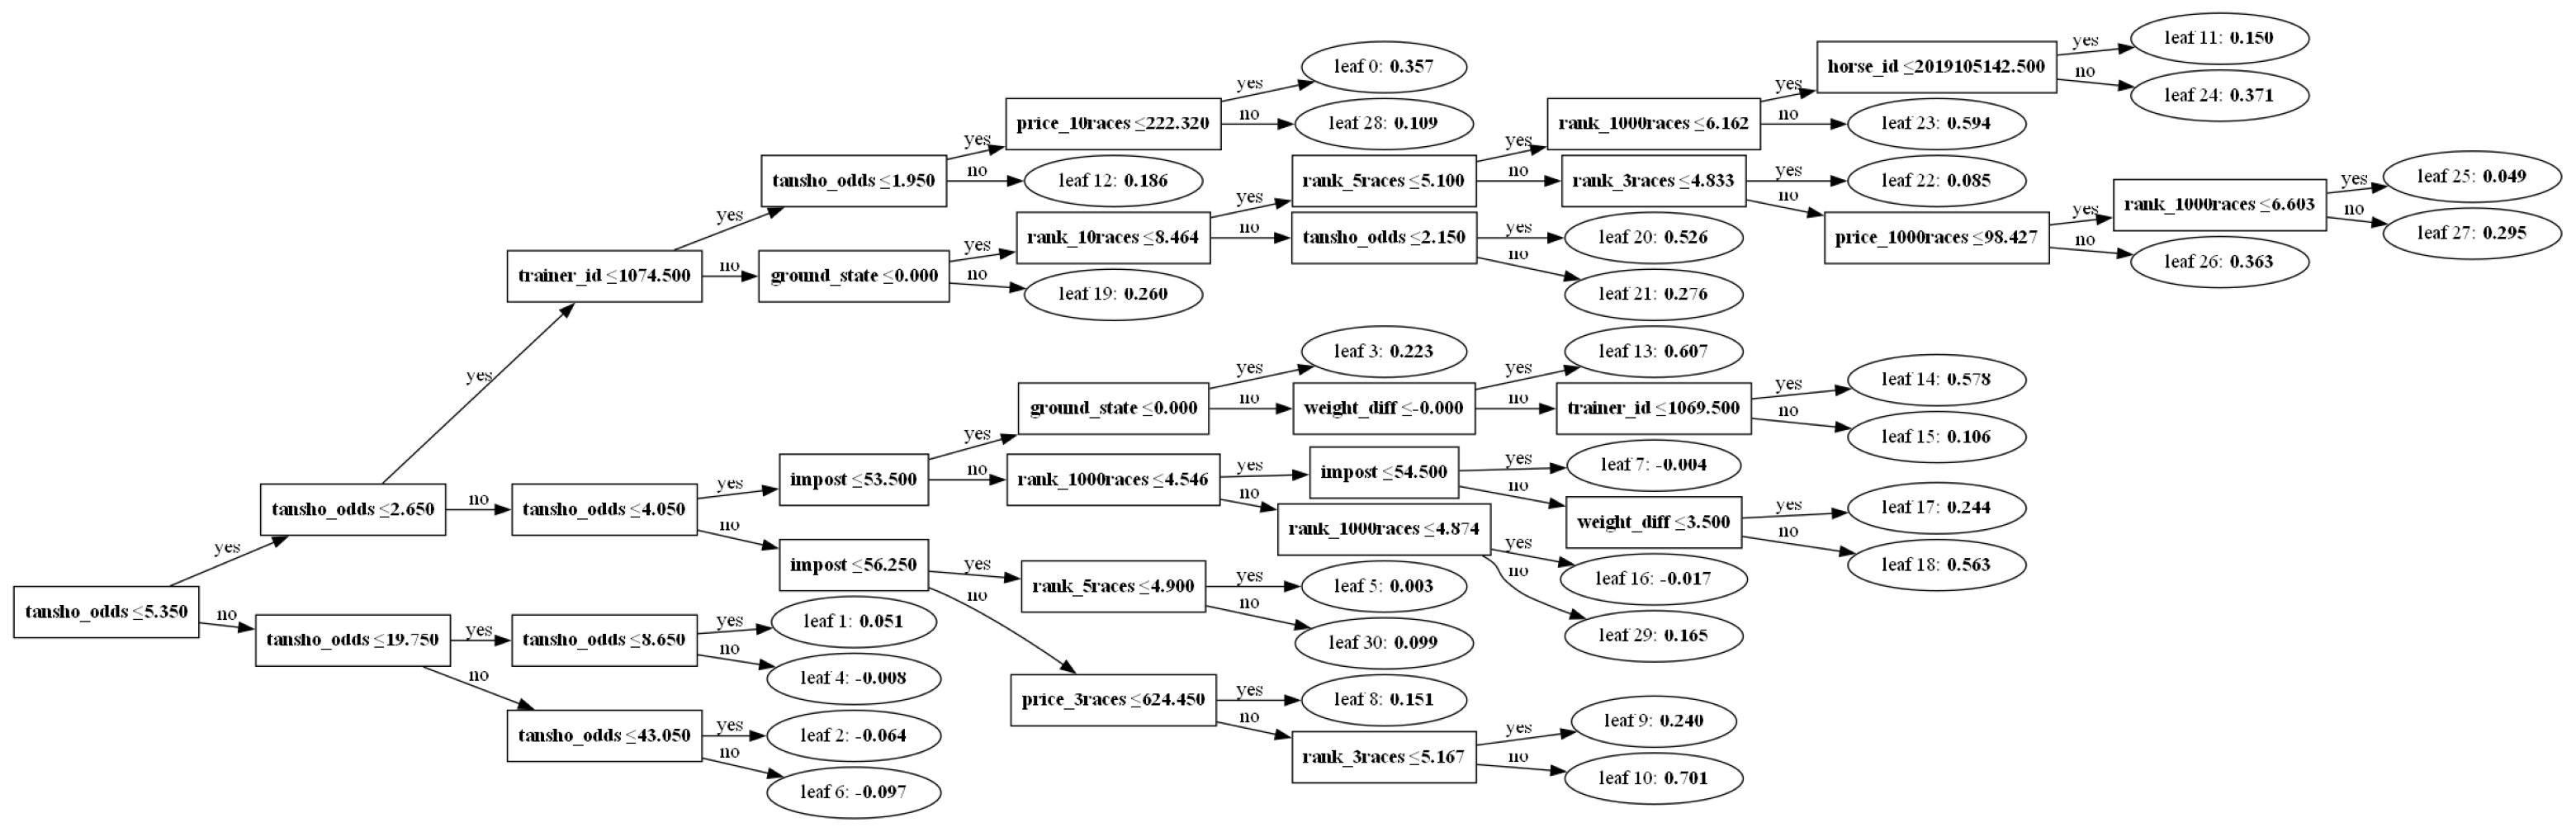

In [32]:
lgb.plot_tree(model, tree_index=1, figsize=(40,20))

In [31]:
import numpy as np

def sigmoid(x):
    return 1/ (1 + np.exp(-x))

sigmoid(-2.279)

np.float64(0.0928771698247447)

### 特徴量重要度
モデルにインプットしたデータの中で、どの特徴量（列）が一番学習に使われているか


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

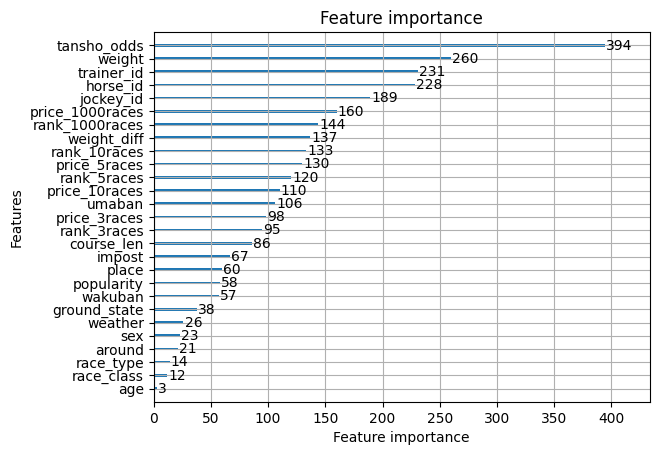

In [35]:
lgb.plot_importance(model, importance_type="split")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

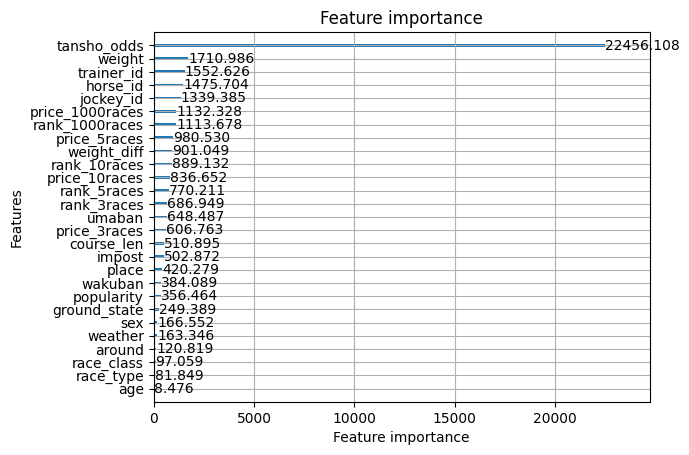

In [ ]:
# 予測の精度にどの要素が一番効いてるか
lgb.plot_importance(model, importance_type="gain")

# 予測時の処理

## レース前日準備

In [4]:
import preprocessing

horse_results_preprocessed = preprocessing.process_horse_results(
    input_filename = "horse_results_prediction.csv",
    output_filename = "horse_results_prediction.csv"
)

In [6]:
horse_results_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6101 entries, 0 to 6100
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   horse_id      6101 non-null   int64         
 1   date          6101 non-null   datetime64[ns]
 2   rank          6101 non-null   int64         
 3   price         6101 non-null   float64       
 4   rank_diff     6048 non-null   float64       
 5   weather       6095 non-null   float64       
 6   race_type     6101 non-null   int64         
 7   course_len    6101 non-null   int64         
 8   ground_state  6098 non-null   float64       
 9   race_class    4757 non-null   float64       
 10  time          6050 non-null   float64       
 11  win           6101 non-null   int64         
 12  rentai        6101 non-null   int64         
 13  show          6101 non-null   int64         
 14  place         6101 non-null   object        
 15  n_horses      6101 non-null   int64   

In [8]:
horse_results_preprocessed[horse_results_preprocessed["rank_diff"].isnull()]

,horse_id,date,rank,price,rank_diff,weather,race_type,course_len,ground_state,race_class,time,win,rentai,show,place,n_horses
56,2016103092,2024-09-14,12,0.0,NaN,0.0,2,3330,0.0,7.0,NaN,0,0,0,中京,12
76,2016103092,2021-11-21,14,0.0,NaN,0.0,2,2770,0.0,1.0,NaN,0,0,0,福島,14
203,2019105759,2025-02-22,11,0.0,NaN,0.0,2,2860,0.0,1.0,NaN,0,0,0,小倉,11
302,2021100256,2024-12-02,7,0.0,NaN,0.0,0,1500,1.0,NaN,NaN,0,0,0,金沢,7
462,2021107317,2024-12-16,0,0.0,NaN,NaN,0,850,NaN,NaN,NaN,0,1,1,水沢,0
495,2021106474,2025-03-19,0,0.0,NaN,2.0,0,800,3.0,NaN,NaN,0,1,1,浦和,0
496,2021106474,2024-12-25,12,0.0,NaN,0.0,0,1500,0.0,NaN,NaN,0,0,0,浦和,12
914,2021104115,2025-06-02,11,0.0,NaN,1.0,0,1500,2.0,NaN,NaN,0,0,0,船橋,11
938,2021106828,2024-06-01,15,0.0,NaN,0.0,1,2000,0.0,1.0,NaN,0,0,0,東京,15
962,2021106798,2024-01-08,15,0.0,NaN,0.0,1,1600,0.0,0.0,NaN,0,0,0,中山,15


# 的中率・回収率シミュレーション

In [10]:
from pathlib import Path
import pandas as pd

RAWDF_DIR = Path("..","..", "common","data", "rawdf")

In [12]:
raw = pd.read_csv(RAWDF_DIR / "return_tables.csv", sep="\t", index_col=0)
raw

,0,1,2,3
race_id,,,,
202301010101,単勝,5,120,1
202301010101,複勝,5 8 6,100 110 310,1 2 6
202301010101,馬連,5 - 8,170,1
202301010101,ワイド,5 - 8 5 - 6 6 - 8,120 600 880,1 8 12
202301010101,馬単,5 → 8,210,1
...,...,...,...,...
202310030812,馬連,8 - 11,940,1
202310030812,ワイド,8 - 11 6 - 8 6 - 11,380 410 470,1 2 4
202310030812,馬単,8 → 11,1580,1


In [14]:
df = raw.loc[raw["0"] == "ワイド", ["1", "2"]]
df

,1,2
race_id,,
202301010101,5 - 8 5 - 6 6 - 8,120 600 880
202301010102,8 - 9 3 - 9 3 - 8,"560 2,710 4,990"
202301010103,4 - 11 9 - 11 4 - 9,370 510 360
202301010104,1 - 9 9 - 13 1 - 13,"1,140 1,620 520"
202301010105,4 - 10 4 - 7 7 - 10,300 380 300
...,...,...
202310030808,4 - 10 3 - 10 3 - 4,"700 2,800 910"
202310030809,14 - 17 12 - 17 12 - 14,"4,300 5,020 16,830"
202310030810,5 - 9 5 - 12 9 - 12,"450 1,240 1,250"


In [15]:
df["2"].str.split(" ")

race_id
202301010101           [120, 600, 880]
202301010102       [560, 2,710, 4,990]
202301010103           [370, 510, 360]
202301010104       [1,140, 1,620, 520]
202301010105           [300, 380, 300]
                         ...          
202310030808         [700, 2,800, 910]
202310030809    [4,300, 5,020, 16,830]
202310030810       [450, 1,240, 1,250]
202310030811           [530, 630, 530]
202310030812           [380, 410, 470]
Name: 2, Length: 3456, dtype: object

In [16]:
df["1"].str.split(" ")

race_id
202301010101          [5, -, 8, 5, -, 6, 6, -, 8]
202301010102          [8, -, 9, 3, -, 9, 3, -, 8]
202301010103        [4, -, 11, 9, -, 11, 4, -, 9]
202301010104        [1, -, 9, 9, -, 13, 1, -, 13]
202301010105        [4, -, 10, 4, -, 7, 7, -, 10]
                              ...                
202310030808        [4, -, 10, 3, -, 10, 3, -, 4]
202310030809    [14, -, 17, 12, -, 17, 12, -, 14]
202310030810        [5, -, 9, 5, -, 12, 9, -, 12]
202310030811        [9, -, 10, 5, -, 10, 5, -, 9]
202310030812        [8, -, 11, 6, -, 8, 6, -, 11]
Name: 1, Length: 3456, dtype: object

In [22]:
df["1"].str.replace(" - ", "-").str.split(" ")

race_id
202301010101          [5-8, 5-6, 6-8]
202301010102          [8-9, 3-9, 3-8]
202301010103        [4-11, 9-11, 4-9]
202301010104        [1-9, 9-13, 1-13]
202301010105        [4-10, 4-7, 7-10]
                        ...          
202310030808        [4-10, 3-10, 3-4]
202310030809    [14-17, 12-17, 12-14]
202310030810        [5-9, 5-12, 9-12]
202310030811        [9-10, 5-10, 5-9]
202310030812        [8-11, 6-8, 6-11]
Name: 1, Length: 3456, dtype: object

In [23]:
# デフォルトは完全一致、regex=Trueは部分一致
df.replace(" - ", "-", regex=True)

,1,2
race_id,,
202301010101,5-8 5-6 6-8,120 600 880
202301010102,8-9 3-9 3-8,"560 2,710 4,990"
202301010103,4-11 9-11 4-9,370 510 360
202301010104,1-9 9-13 1-13,"1,140 1,620 520"
202301010105,4-10 4-7 7-10,300 380 300
...,...,...
202310030808,4-10 3-10 3-4,"700 2,800 910"
202310030809,14-17 12-17 12-14,"4,300 5,020 16,830"
202310030810,5-9 5-12 9-12,"450 1,240 1,250"


DataFrameで列ごとに処理を適用したい場合：apply(lambda x:処理(x))を使う

In [25]:
# splitはデフォルトで半角スペースで分割
df.replace(" - ", "-", regex=True).apply(lambda x: x.str.split())

,1,2
race_id,,
202301010101,"[5-8, 5-6, 6-8]","[120, 600, 880]"
202301010102,"[8-9, 3-9, 3-8]","[560, 2,710, 4,990]"
202301010103,"[4-11, 9-11, 4-9]","[370, 510, 360]"
202301010104,"[1-9, 9-13, 1-13]","[1,140, 1,620, 520]"
202301010105,"[4-10, 4-7, 7-10]","[300, 380, 300]"
...,...,...
202310030808,"[4-10, 3-10, 3-4]","[700, 2,800, 910]"
202310030809,"[14-17, 12-17, 12-14]","[4,300, 5,020, 16,830]"
202310030810,"[5-9, 5-12, 9-12]","[450, 1,240, 1,250]"


In [28]:
# explode関数でリスト型の列を行ごと分割
df.replace(" - ", "-", regex=True).apply(lambda x: x.str.split()).explode(["1", "2"])

,1,2
race_id,,
202301010101,5-8,120
202301010101,5-6,600
202301010101,6-8,880
202301010102,8-9,560
202301010102,3-9,"2,710"
...,...,...
202310030811,5-10,630
202310030811,5-9,530
202310030812,8-11,380


In [34]:
tmp = (
    df.replace(" - ", "-", regex=True)
    .apply(lambda x: x.str.split())
    .explode(["1", "2"])
    .apply(lambda  x: x.str.split("-"))
    .explode("2")
    .replace(",", "", regex=True)
)
tmp["2"] = tmp["2"].astype(int)

In [35]:
tmp

,1,2
race_id,,
202301010101,"[5, 8]",120
202301010101,"[5, 6]",600
202301010101,"[6, 8]",880
202301010102,"[8, 9]",560
202301010102,"[3, 9]",2710
...,...,...
202310030811,"[5, 10]",630
202310030811,"[5, 9]",530
202310030812,"[8, 11]",380


In [36]:
raw

,0,1,2,3
race_id,,,,
202301010101,単勝,5,120,1
202301010101,複勝,5 8 6,100 110 310,1 2 6
202301010101,馬連,5 - 8,170,1
202301010101,ワイド,5 - 8 5 - 6 6 - 8,120 600 880,1 8 12
202301010101,馬単,5 → 8,210,1
...,...,...,...,...
202310030812,馬連,8 - 11,940,1
202310030812,ワイド,8 - 11 6 - 8 6 - 11,380 410 470,1 2 4
202310030812,馬単,8 → 11,1580,1


In [37]:
raw.head(10)

,0,1,2,3
race_id,,,,
202301010101,単勝,5,120,1
202301010101,複勝,5 8 6,100 110 310,1 2 6
202301010101,馬連,5 - 8,170,1
202301010101,ワイド,5 - 8 5 - 6 6 - 8,120 600 880,1 8 12
202301010101,馬単,5 → 8,210,1
202301010101,三連複,5 - 6 - 8,1120,4
202301010101,三連単,5 → 8 → 6,2680,9
202301010102,単勝,9,240,1
202301010102,複勝,9 8 3,140 280 990,1 5 11


In [38]:
df = raw.loc[raw["0"] == "馬単", ["1", "2"]]
df

,1,2
race_id,,
202301010101,5 → 8,210
202301010102,9 → 8,2020
202301010103,11 → 4,2580
202301010104,9 → 1,10010
202301010105,4 → 10,1430
...,...,...
202310030808,10 → 4,3320
202310030809,17 → 14,26080
202310030810,5 → 9,2130


In [44]:
(
    df.replace(" → ", "→", regex=True)
    .apply(lambda x: x.str.split())
    .explode(["1", "2"])
    .apply(lambda x: x.str.split("-"))
    .explode("2")
    .replace(",", "", regex=True)
)

,1,2
race_id,,
202301010101,[5→8],210
202301010102,[9→8],2020
202301010103,[11→4],2580
202301010104,[9→1],10010
202301010105,[4→10],1430
...,...,...
202310030808,[10→4],3320
202310030809,[17→14],26080
202310030810,[5→9],2130


In [45]:
df = raw.loc[raw["0"] == "三連複", ["1", "2"]]
df

,1,2
race_id,,
202301010101,5 - 6 - 8,1120
202301010102,3 - 8 - 9,18440
202301010103,4 - 9 - 11,1930
202301010104,1 - 9 - 13,7060
202301010105,4 - 7 - 10,1040
...,...,...
202310030808,3 - 4 - 10,8280
202310030809,12 - 14 - 17,130230
202310030810,5 - 9 - 12,4500


In [46]:
(
    df.replace(" - ", "-", regex=True)
    .apply(lambda x: x.str.split())
    .explode(["1", "2"])
    .apply(lambda x: x.str.split("-"))
    .explode("2")
    .replace(",", "", regex=True)
)

,1,2
race_id,,
202301010101,"[5, 6, 8]",1120
202301010102,"[3, 8, 9]",18440
202301010103,"[4, 9, 11]",1930
202301010104,"[1, 9, 13]",7060
202301010105,"[4, 7, 10]",1040
...,...,...
202310030808,"[3, 4, 10]",8280
202310030809,"[12, 14, 17]",130230
202310030810,"[5, 9, 12]",4500


In [47]:
(
    df.replace(" - ", "-", regex=True)
    .apply(lambda x: x.str.split())
    .explode(["1", "2"])
    .apply(lambda x: x.str.split("-"))
    .explode("2")
).index.value_counts() 

race_id
202305050211    2
202301020112    2
202301010403    2
202305020904    2
202305040805    2
               ..
202301010112    1
202301010201    1
202301010202    1
202301010203    1
202301010204    1
Name: count, Length: 3456, dtype: int64

In [51]:
(
    raw[["0", "1", "2"]]
    .replace(" (-|→) ", "-", regex=True)
    .replace(",", "", regex=True)
    .apply(lambda x: x.str.split())
    .explode(["1", "2"])
    .explode("0")
    .apply(lambda x: x.str.split("-"))
    .explode(["0", "2"])
)

,0,1,2
race_id,,,
202301010101,単勝,[5],120
202301010101,複勝,[5],100
202301010101,複勝,[8],110
202301010101,複勝,[6],310
202301010101,馬連,"[5, 8]",170
...,...,...,...
202310030812,ワイド,"[6, 8]",410
202310030812,ワイド,"[6, 11]",470
202310030812,馬単,"[8, 11]",1580


In [3]:
import preprocessing
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload

In [5]:
df = preprocessing.process_return_tables()

# データチェック

In [6]:
df

,bet_type,win_umaban,return
race_id,,,
202301010101,単勝,[5],120
202301010101,複勝,[5],100
202301010101,複勝,[8],110
202301010101,複勝,[6],310
202301010101,馬連,"[5, 8]",170
...,...,...,...
202310030812,ワイド,"[6, 8]",410
202310030812,ワイド,"[6, 11]",470
202310030812,馬単,"[8, 11]",1580


In [11]:
tmp = df.loc[df["bet_type"] == "単勝", ["umaban", "return"]]
tmp

,umaban,return
race_id,,
202301010101,[5],120
202301010102,[9],240
202301010103,[11],840
202301010104,[9],1970
202301010105,[4],460
...,...,...
202310030808,[10],830
202310030809,[17],850
202310030810,[5],500


In [16]:
tmp = tmp.explode("umaban").astype(int)

In [17]:
tmp.index.nunique()

3456

In [18]:
tmp.index.value_counts()

race_id
202302010610    2
202306040308    2
202304010810    2
202310030605    1
202310030606    1
               ..
202301010112    1
202301010201    1
202301010202    1
202301010203    1
202301010204    1
Name: count, Length: 3456, dtype: int64

In [19]:
tmp.query("race_id == 202302010610")

,umaban,return
race_id,,
202302010610,5,490
202302010610,9,1040


In [20]:
tmp = df.loc[df["bet_type"] == "複勝", ["umaban", "return"]]
tmp

,umaban,return
race_id,,
202301010101,[5],100
202301010101,[8],110
202301010101,[6],310
202301010102,[9],140
202301010102,[8],280
...,...,...
202310030811,[9],150
202310030811,[5],190
202310030812,[8],160


In [21]:
tmp = tmp.explode("umaban").astype(int)

In [22]:
tmp = tmp.explode("umaban").astype(int)

In [23]:
tmp.index.nunique()

3456

In [24]:
tmp.index.value_counts()

race_id
202305050211    4
202301020112    4
202304040211    4
202305040805    4
202305020904    4
               ..
202301020605    2
202301020502    2
202301020201    2
202301010605    2
202301010205    2
Name: count, Length: 3456, dtype: int64

In [27]:
tmp.query("race_id == 202308020808")

,umaban,return
race_id,,
202308020808,5,120
202308020808,2,140


In [28]:
tmp = df.loc[df["bet_type"] == "馬連", ["umaban", "return"]]
tmp

,umaban,return
race_id,,
202301010101,"[5, 8]",170
202301010102,"[8, 9]",1470
202301010103,"[4, 11]",990
202301010104,"[1, 9]",4420
202301010105,"[4, 10]",740
...,...,...
202310030808,"[4, 10]",1450
202310030809,"[14, 17]",14420
202310030810,"[5, 9]",1060


In [29]:
tmp.index.value_counts()

race_id
202304040509    2
202309050306    2
202310010106    2
202310030607    1
202310030608    1
               ..
202301010112    1
202301010201    1
202301010202    1
202301010203    1
202301010204    1
Name: count, Length: 3456, dtype: int64

In [31]:
tmp.query("race_id == 202310010106")

,umaban,return
race_id,,
202310010106,"[1, 10]",1340
202310010106,"[7, 10]",4040


In [33]:
# リストの要素は全て2であるか
tmp["umaban"].apply(len).value_counts()

umaban
2    3459
Name: count, dtype: int64

# シミュレーションの作成

In [23]:
from train import Trainer

trainer = Trainer()
evaluation_df = trainer.run(test_start_date="2023-10-01")

[100]	training's binary_logloss: 0.15511	valid_1's binary_logloss: 0.208311


In [24]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred
6254,202303030101,2021100761,0,10,2.1,1,1,0.329372
6255,202303030101,2021106736,0,14,398.2,15,2,0.000595
6256,202303030101,2021107376,0,15,177.5,12,3,0.001736
6257,202303030101,2021109129,0,7,94.7,7,4,0.004853
6258,202303030101,2021103986,0,12,173.0,11,5,0.000927
...,...,...,...,...,...,...,...,...
43507,202309050912,2019103898,0,2,5.9,3,12,0.237050
43508,202309050912,2019106102,0,8,11.9,6,13,0.068244
43509,202309050912,2017102603,0,16,347.8,14,14,0.000561
43510,202309050912,2019100653,0,13,94.7,12,15,0.002776


In [44]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("..", "data")
PREPROCESSED_DIR = DATA_DIR / "01_preprocessed"

return_tables = pd.read_pickle(PREPROCESSED_DIR / "return_tables.pickle")
return_tables.rename(columns={"umaban": "win_umaban"}, inplace=True)

In [45]:
return_tables.head(10)

,bet_type,win_umaban,return
race_id,,,
202301010101,単勝,[5],120
202301010101,複勝,[5],100
202301010101,複勝,[8],110
202301010101,複勝,[6],310
202301010101,馬連,"[5, 8]",170
202301010101,ワイド,"[5, 8]",120
202301010101,ワイド,"[5, 6]",600
202301010101,ワイド,"[6, 8]",880
202301010101,馬単,"[5, 8]",210


# どう作るか
- 目的：馬券購入の最適化ではなく、あくまで「制度を計測する指標」として作る
- 予測スコア上位5着で、3頭BOXを買う場合を考える
- 複雑な場合を先に想定してコードを書いておいた方が、統一感が出る
- 予測スコア上位n着で、それぞれBOXを買う場合を考える

In [49]:
bet_df = (
    evaluation_df.sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(5)
    .groupby("race_id")["umaban"]
    .apply(lambda x: list(x.astype(str)))
    .reset_index()
)
bet_df

,race_id,umaban
0,202303030101,"[1, 15, 8, 10, 7]"
1,202303030102,"[7, 11, 1, 5, 2]"
2,202303030103,"[3, 4, 12, 9, 6]"
3,202303030104,"[9, 1, 4, 8, 6]"
4,202303030105,"[2, 14, 12, 4, 1]"
...,...,...
859,202309050908,"[8, 4, 14, 12, 15]"
860,202309050909,"[13, 16, 5, 15, 12]"
861,202309050910,"[11, 1, 7, 9, 6]"
862,202309050911,"[10, 5, 15, 11, 12]"


In [32]:
grouped_df = (
    evaluation_df.sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(5)
    .groupby("race_id")
)

In [34]:
for key, df in grouped_df:
    print(list(df["umaban"]))
    break

[1, 15, 8, 10, 7]


In [38]:
bet_df

,race_id,umaban
0,202303030101,"[1, 15, 8, 10, 7]"
1,202303030102,"[7, 11, 1, 5, 2]"
2,202303030103,"[3, 4, 12, 9, 6]"
3,202303030104,"[9, 1, 4, 8, 6]"
4,202303030105,"[2, 14, 12, 4, 1]"
...,...,...
859,202309050908,"[8, 4, 14, 12, 15]"
860,202309050909,"[13, 16, 5, 15, 12]"
861,202309050910,"[11, 1, 7, 9, 6]"
862,202309050911,"[10, 5, 15, 11, 12]"


In [39]:
return_tables

,bet_type,umaban,return
race_id,,,
202301010101,単勝,[5],120
202301010101,複勝,[5],100
202301010101,複勝,[8],110
202301010101,複勝,[6],310
202301010101,馬連,"[5, 8]",170
...,...,...,...
202310030812,ワイド,"[6, 8]",410
202310030812,ワイド,"[6, 11]",470
202310030812,馬単,"[8, 11]",1580


In [52]:
df = bet_df.merge(return_tables, on="race_id")
df

,race_id,umaban,bet_type,win_umaban,return
0,202303030101,"[1, 15, 8, 10, 7]",単勝,[8],470
1,202303030101,"[1, 15, 8, 10, 7]",複勝,[8],220
2,202303030101,"[1, 15, 8, 10, 7]",複勝,[7],300
3,202303030101,"[1, 15, 8, 10, 7]",複勝,[15],290
4,202303030101,"[1, 15, 8, 10, 7]",枠連,"[4, 5]",1480
...,...,...,...,...,...
10333,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[2, 5]",1380
10334,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[5, 12]",460
10335,202309050912,"[12, 5, 6, 1, 13]",馬単,"[2, 12]",29610
10336,202309050912,"[12, 5, 6, 1, 13]",三連複,"[2, 5, 12]",7370


In [53]:
x = df.iloc[3]["umaban"]
x

['1', '15', '8', '10', '7']

In [51]:
y = df.iloc[3]["win_umaban"]
y

['15']

In [ ]:
set(y).issubset(set(x)) # xがyを含むか

True

In [59]:
# applyはデフォルトで列ごとに処理される
# axis=1にすると行ごとに処理されるようになる
df["hit"] = df.apply(
    lambda  x: set(x["win_umaban"]).issubset(set(x["umaban"])), axis=1
)
df

,race_id,umaban,bet_type,win_umaban,return,hit
0,202303030101,"[1, 15, 8, 10, 7]",単勝,[8],470,True
1,202303030101,"[1, 15, 8, 10, 7]",複勝,[8],220,True
2,202303030101,"[1, 15, 8, 10, 7]",複勝,[7],300,True
3,202303030101,"[1, 15, 8, 10, 7]",複勝,[15],290,True
4,202303030101,"[1, 15, 8, 10, 7]",枠連,"[4, 5]",1480,False
...,...,...,...,...,...,...
10333,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[2, 5]",1380,False
10334,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[5, 12]",460,True
10335,202309050912,"[12, 5, 6, 1, 13]",馬単,"[2, 12]",29610,False
10336,202309050912,"[12, 5, 6, 1, 13]",三連複,"[2, 5, 12]",7370,False


In [61]:
(
    df.groupby(["race_id", "bet_type"])["hit"]
    .max()
    .groupby("bet_type")
    .mean()
)

bet_type
ワイド    0.831019
三連単    0.347222
三連複    0.347222
単勝     0.828704
枠連     0.190073
複勝     0.986111
馬単     0.584491
馬連     0.584491
Name: hit, dtype: float64

In [62]:
df["hit_return"] = df["return"] * df["hit"]
df

,race_id,umaban,bet_type,win_umaban,return,hit,hit_return
0,202303030101,"[1, 15, 8, 10, 7]",単勝,[8],470,True,470
1,202303030101,"[1, 15, 8, 10, 7]",複勝,[8],220,True,220
2,202303030101,"[1, 15, 8, 10, 7]",複勝,[7],300,True,300
3,202303030101,"[1, 15, 8, 10, 7]",複勝,[15],290,True,290
4,202303030101,"[1, 15, 8, 10, 7]",枠連,"[4, 5]",1480,False,0
...,...,...,...,...,...,...,...
10333,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[2, 5]",1380,False,0
10334,202309050912,"[12, 5, 6, 1, 13]",ワイド,"[5, 12]",460,True,460
10335,202309050912,"[12, 5, 6, 1, 13]",馬単,"[2, 12]",29610,False,0
10336,202309050912,"[12, 5, 6, 1, 13]",三連複,"[2, 5, 12]",7370,False,0


In [66]:
import math

math.comb(5, 2)

10

In [71]:
n_bets_dict = {
    "単勝": 5,
    "複勝": 5,
    "馬連": math.comb(5, 2),
    "ワイド": math.comb(5, 2),
    "馬単": math.perm(5, 2),
    "三連複": math.comb(5, 3),
    "三連単": math.perm(5, 3)
}

In [70]:
agg_df = (
    df.groupby(["race_id", "bet_type"])["hit_return"]
    .sum()
    .reset_index()
)
agg_df

,race_id,bet_type,hit_return
0,202303030101,ワイド,2260
1,202303030101,三連単,21460
2,202303030101,三連複,4320
3,202303030101,単勝,470
4,202303030101,枠連,0
...,...,...,...
6869,202309050912,単勝,0
6870,202309050912,枠連,2990
6871,202309050912,複勝,360
6872,202309050912,馬単,0


In [73]:
agg_df["n_bets"] = agg_df["bet_type"].map(n_bets_dict)
agg_df

,race_id,bet_type,hit_return,n_bets
0,202303030101,ワイド,2260,10.0
1,202303030101,三連単,21460,60.0
2,202303030101,三連複,4320,10.0
3,202303030101,単勝,470,5.0
4,202303030101,枠連,0,NaN
...,...,...,...,...
6869,202309050912,単勝,0,5.0
6870,202309050912,枠連,2990,NaN
6871,202309050912,複勝,360,5.0
6872,202309050912,馬単,0,20.0


In [75]:
agg_df = agg_df.groupby("bet_type")[["hit_return", "n_bets"]].sum()
agg_df

,hit_return,n_bets
bet_type,,
ワイド,711360,8640.0
三連単,3854950,51840.0
三連複,668280,8640.0
単勝,360750,4320.0
枠連,230640,0.0
複勝,357290,4320.0
馬単,1303680,17280.0
馬連,675740,8640.0


In [76]:
agg_df["hit_return"] / agg_df["n_bets"] / 100

bet_type
ワイド    0.823333
三連単    0.743625
三連複    0.773472
単勝     0.835069
枠連          inf
複勝     0.827060
馬単     0.754444
馬連     0.782106
dtype: float64

# クラスにまとめる

In [1]:
from evaluation import Evaluator
import pandas as pd
%load_ext autoreload

In [28]:
%autoreload

[autoreload of evaluation failed: Traceback (most recent call last):
  File "d:\tools\Python\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tools\Python\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
UnicodeDecodeError: 'cp932' codec can't decode byte 0x87 in position 876: illegal multibyte sequence
]


In [3]:
evaluation = Evaluator()
agg_df = evaluation.box_top_n(n=1)

In [7]:
agg_df

(bet_type
 ワイド    0.000000
 三連単    0.000000
 三連複    0.000000
 単勝     0.321759
 枠連     0.004843
 複勝     0.616898
 馬単     0.000000
 馬連     0.000000
 Name: hit, dtype: float64,
 bet_type
 単勝    0.825116
 複勝    0.826736
 dtype: float64)

In [ ]:
agg_df.query("n_bets > 0")["bet_type"].value_counts()

AttributeError: 'tuple' object has no attribute 'query'

In [2]:
evaluation = Evaluator()
agg_hitrate, agg_returnrate = evaluation.box_top_n(n=2)

In [25]:
agg_hitrate = agg_hitrate.rename("hitrate").to_frame()
agg_hitrate

,hitrate
bet_type,
ワイド,0.319444
三連単,0.000000
三連複,0.000000
単勝,0.545139
枠連,0.033898
複勝,0.837963
馬単,0.159722
馬連,0.159722


In [26]:
agg_returnrate = agg_returnrate.rename("returnrate").to_frame()
agg_returnrate

,returnrate
bet_type,
ワイド,0.854167
単勝,0.881192
複勝,0.856655
馬単,0.861574
馬連,0.865394


In [ ]:
# left_indexとright_indexで結合する、両方ともTrue場合はinner join
pd.merge(agg_hitrate, agg_returnrate, left_index=True, right_index=True)

,hitrate,returnrate
bet_type,,
ワイド,0.319444,0.854167
単勝,0.545139,0.881192
複勝,0.837963,0.856655
馬単,0.159722,0.861574
馬連,0.159722,0.865394


In [2]:
evaluation = Evaluator()
agg_df = evaluation.box_top_n(n=2)

In [4]:
agg_df

,hitrate,returnrate
bet_type,,
ワイド,0.319444,0.854167
単勝,0.545139,0.881192
複勝,0.837963,0.856655
馬単,0.159722,0.861574
馬連,0.159722,0.865394


In [5]:
agg_popularity = evaluation.box_top_n(
    sort_col = "popularity",
    ascending= True,
    n=2,
    exp_name="popularity"
)
agg_popularity

,hitrate_popularity,returnrate_popularity
bet_type,,
ワイド,0.324074,0.809606
単勝,0.543981,0.836285
複勝,0.842593,0.839410
馬単,0.170139,0.811748
馬連,0.170139,0.829977


In [9]:
pd.concat([agg_df, agg_popularity], axis=1).sort_index(axis=1)

,hitrate_model,hitrate_popularity,returnrate_model,returnrate_popularity
bet_type,,,,
ワイド,0.319444,0.324074,0.854167,0.809606
単勝,0.545139,0.543981,0.881192,0.836285
複勝,0.837963,0.842593,0.856655,0.839410
馬単,0.159722,0.170139,0.861574,0.811748
馬連,0.159722,0.170139,0.865394,0.829977
